In [ ]:
from __future__ import annotations

In [ ]:
# Simplified data loading (supervised)
from pathlib import Path

import pandas as pd

# Paths
DATA_DIR = Path("..") / "data" / "model_ready"
CSV = DATA_DIR / "cpt_dataset_total.csv"

# Features and label
FEATURES = [
    "Depth (m)",
    "qc (MPa)",
    "fs (kPa)",
    "Rf (%)",
    "σ,v (kPa)",
    "u0 (kPa)",
    "σ',v (kPa)",
    "Qtn (-)",
    "Fr (%)",
]
LABEL = "Oberhollenzer_classes"

# Load dataset and split into features/label
df = pd.read_csv(CSV)
X = df[FEATURES].copy()
y = df[LABEL].copy()

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"X: {X.shape} | y: {y.shape}")
X.head(3)

# Hydra Configuration System: A Hands-on Tutorial

This notebook demonstrates how to use Hydra for clean, reproducible configuration management in applied machine learning. We'll use a synthetic geotechnical-like dataset and show two patterns:

- Programmatic API: initialize/compose configs directly in cells (great inside notebooks).
- Decorator API: `@hydra.main` for scripts (shown inline but executed carefully in notebooks).

What you'll learn:
- Organizing configs with groups (dataset/, model/) and defaults
- Overriding values at runtime
- Saving outputs to per-run directories
- Running simple parameter sweeps in-notebook (no plugins needed)
- Logging a run to MLflow while keeping Hydra as the source of truth

We keep most code at the top-level in cells for easier inspection and debugging.

## Setup and Imports

We rely on packages already declared in `pyproject.toml` (hydra-core, numpy, pandas, scikit-learn, seaborn, matplotlib, mlflow). If your environment isn't synced, run `uv sync` before executing the notebook.

In [ ]:
# moved __future__ import to the first cell
from itertools import product
from pathlib import Path

import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from hydra import compose, initialize_config_dir
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="whitegrid")
RNG_SEED = 42
np.random.seed(RNG_SEED)

# Paths for configs and outputs
# Robustly find the project root by looking for a marker file/folder
_cwd = Path.cwd().resolve()
markers = {"pyproject.toml", ".git", "README.md"}
PROJECT_ROOT = None
for p in [_cwd] + list(_cwd.parents):
    if any((p / m).exists() for m in markers):
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    # Fallback to notebook's parent directory
    PROJECT_ROOT = (
        Path(__file__).resolve().parents[2] if "__file__" in globals() else _cwd
    )

CONFIG_DIR = PROJECT_ROOT / "notebooks" / "config" / "hydra_demo"
OUTPUT_ROOT = PROJECT_ROOT / "notebooks" / "outputs" / "hydra"

print("Detected PROJECT_ROOT:", PROJECT_ROOT)
print("CONFIG_DIR exists:", CONFIG_DIR.exists())
print("OUTPUT_ROOT exists:", OUTPUT_ROOT.exists())
CONFIG_DIR.exists(), OUTPUT_ROOT.exists()

Detected PROJECT_ROOT: C:\Users\TFH\git_projects\course-machine-learning-for-geotechnics
CONFIG_DIR exists: True
OUTPUT_ROOT exists: True


(True, True)

## Inspect the Config Tree

We created a tiny config tree in `notebooks/config/hydra_demo/`:
- `main.yaml` with defaults and Hydra's run dir
- `dataset/synthetic.yaml` with dataset parameters
- `model/logreg.yaml` with model hyperparameters

Let's load and print the composed config using Hydra's programmatic API.

In [7]:
with initialize_config_dir(version_base="1.3", config_dir=str(CONFIG_DIR)):
    cfg = compose(config_name="main.yaml")
print(OmegaConf.to_yaml(cfg))

dataset:
  name: synthetic
  type: synthetic
  size: 800
  test_size: 0.25
  features:
  - depth
  - qc
  - fs
  - Fr
  - noise
  target: 'y'
model:
  name: logistic_regression
  type: logreg
  max_iter: 1000
  penalty: l2
  C: 1.0
  solver: lbfgs
  scaler: standard
  grid:
    C:
    - 0.1
    - 1.0
    - 10.0
    penalty:
    - l2
experiment:
  name: hydra_demo
  seed: 42



## Generate a Synthetic CPT-like Dataset

We'll simulate a small dataset with features often seen in CPT contexts (depth, qc, fs, Fr, noise) and a 3-class target.

In [8]:
# Read dataset settings from cfg.dataset
n = int(cfg.dataset.size)
test_size = float(cfg.dataset.test_size)
features = list(cfg.dataset.features)

# Synthetic generation
depth = np.sort(np.random.uniform(0.0, 30.0, size=n))
qc = np.clip(np.random.lognormal(mean=1.4, sigma=0.6, size=n), 0.2, None)
fs = np.clip(np.random.lognormal(mean=-0.2, sigma=0.5, size=n) * 0.1, 0.002, None)
Fr = 100.0 * fs / np.clip(qc, 1e-6, None)
noise = np.random.normal(0.0, 1.0, size=n)

# Simple label rule for demo (3 classes)
y = np.where((qc > 7.5) & (Fr < 1.5), 0, np.where((qc < 2.5) & (Fr > 2.5), 2, 1))

df = pd.DataFrame(
    {"depth": depth, "qc": qc, "fs": fs, "Fr": Fr, "noise": noise, "y": y}
)
df.head()

,depth,qc,fs,Fr,noise,y
0,0.151848,2.523673,0.107159,4.246172,-0.358340,1
1,0.165664,5.381037,0.139969,2.601161,-0.647542,1
2,0.208564,12.543652,0.068217,0.543837,0.744192,0
3,0.275912,9.090701,0.053816,0.591986,-0.181224,0
4,0.325130,10.547744,0.048558,0.460367,-0.649373,0


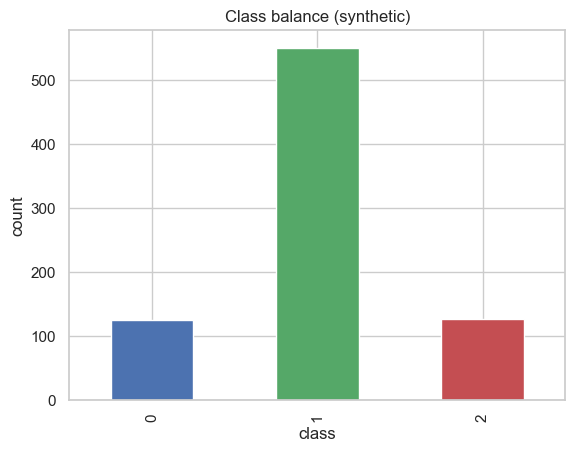

In [9]:
ax = (
    df["y"]
    .value_counts()
    .sort_index()
    .plot(kind="bar", color=["#4C72B0", "#55A868", "#C44E52"])
)
ax.set_xlabel("class")
ax.set_ylabel("count")
ax.set_title("Class balance (synthetic)")
plt.show()

## Single Run with Programmatic Hydra Compose

We'll read model config, fit Logistic Regression with scaling, evaluate accuracy, and save artifacts to the Hydra run directory specified in `main.yaml`.

In [14]:
X = df[features].copy()
y = df["y"].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=cfg.experiment.seed, stratify=y
)

# Model hyperparameters from cfg.model
C = float(cfg.model.C)
penalty = str(cfg.model.penalty)
max_iter = int(cfg.model.max_iter)
solver = str(cfg.model.solver)

# Optional scaling
if str(cfg.model.scaler) == "standard":
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
else:
    X_train_s, X_test_s = X_train.values, X_test.values

clf = LogisticRegression(
    C=C, penalty=penalty, max_iter=max_iter, solver=solver, n_jobs=None
)
clf.fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred, digits=3))

# Create run directory based on hydra.run.dir
with initialize_config_dir(version_base="1.3", config_dir=str(CONFIG_DIR)):
    run_cfg = compose(config_name="main.yaml", return_hydra_config=True)
# Resolve only the hydra.run subtree to avoid sweep-related interpolations
run_run = OmegaConf.to_container(run_cfg.hydra.run, resolve=True)
run_dir = (PROJECT_ROOT / run_run["dir"]).resolve()  # type: ignore[index]
run_dir.mkdir(parents=True, exist_ok=True)

# Save artifacts
(run_dir / "config.yaml").write_text(OmegaConf.to_yaml(cfg))
df.head(50).to_csv(run_dir / "preview.csv", index=False)
pd.DataFrame({"feature": features}).to_csv(run_dir / "features.csv", index=False)
print("Artifacts saved to:", run_dir)
run_dir

Accuracy: 0.935
              precision    recall  f1-score   support

           0      0.963     0.839     0.897        31
           1      0.919     0.993     0.955       138
           2      1.000     0.774     0.873        31

    accuracy                          0.935       200
   macro avg      0.961     0.869     0.908       200
weighted avg      0.939     0.935     0.933       200

Artifacts saved to: C:\Users\TFH\git_projects\course-machine-learning-for-geotechnics\notebooks\outputs\hydra\2025-09-18\23-56-30


WindowsPath('C:/Users/TFH/git_projects/course-machine-learning-for-geotechnics/notebooks/outputs/hydra/2025-09-18/23-56-30')

## Overrides: Change Config Values on the Fly

Hydra allows overriding config values without editing YAML. Below we override `model.C` and `dataset.test_size`.

In [15]:
with initialize_config_dir(version_base="1.3", config_dir=str(CONFIG_DIR)):
    cfg_over = compose(
        config_name="main.yaml", overrides=["model.C=10.0", "dataset.test_size=0.3"]
    )
print(OmegaConf.to_yaml(cfg_over))

dataset:
  name: synthetic
  type: synthetic
  size: 800
  test_size: 0.3
  features:
  - depth
  - qc
  - fs
  - Fr
  - noise
  target: 'y'
model:
  name: logistic_regression
  type: logreg
  max_iter: 1000
  penalty: l2
  C: 10.0
  solver: lbfgs
  scaler: standard
  grid:
    C:
    - 0.1
    - 1.0
    - 10.0
    penalty:
    - l2
experiment:
  name: hydra_demo
  seed: 42



## Simple Parameter Sweep (in-notebook)

We'll emulate a small grid search using config values. This isn't using the Hydra multirun CLI, but it demonstrates how configs drive experiments.

In [ ]:
grid_C = list(cfg.model.grid.C)
penalty_values = list(cfg.model.grid.penalty)
results = []
for C_val, pen in product(grid_C, penalty_values):
    with initialize_config_dir(version_base="1.3", config_dir=str(CONFIG_DIR)):
        cfg_try = compose(
            config_name="main.yaml",
            overrides=[f"model.C={C_val}", f"model.penalty={pen}"],
        )
    # Prepare data
    X = df[features].copy()
    y = df["y"].copy()
    X_tr, X_te, y_tr, y_te = train_test_split(
        X,
        y,
        test_size=float(cfg_try.dataset.test_size),
        random_state=cfg_try.experiment.seed,
        stratify=y,
    )
    if str(cfg_try.model.scaler) == "standard":
        sc = StandardScaler()
        X_tr_s = sc.fit_transform(X_tr)
        X_te_s = sc.transform(X_te)
    else:
        X_tr_s, X_te_s = X_tr.values, X_te.values
    model = LogisticRegression(
        C=float(cfg_try.model.C),
        penalty=str(cfg_try.model.penalty),
        max_iter=int(cfg_try.model.max_iter),
        solver=str(cfg_try.model.solver),
    )
    model.fit(X_tr_s, y_tr)
    acc_te = accuracy_score(y_te, model.predict(X_te_s))
    results.append({"C": float(C_val), "penalty": str(pen), "acc": acc_te})
res_df = pd.DataFrame(results).sort_values("acc", ascending=False)
res_df

## Logging One Run with MLflow

We'll log parameters and metrics to MLflow to show how Hydra configs can drive experiment tracking. The MLflow tracking directory for this repo is `experiments/`.

In [ ]:
mlflow.set_tracking_uri(str((PROJECT_ROOT / "experiments").resolve()))
mlflow.set_experiment("hydra_demo_notebook")

with mlflow.start_run(run_name="single_run"):
    mlflow.log_params(
        {
            "dataset": cfg.dataset.name,
            "test_size": float(cfg.dataset.test_size),
            "features": ",".join(features),
            "model": cfg.model.name,
            "C": float(cfg.model.C),
            "penalty": str(cfg.model.penalty),
            "solver": str(cfg.model.solver),
            "max_iter": int(cfg.model.max_iter),
        }
    )
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_artifact(str(run_dir / "config.yaml"))
    mlflow.log_artifact(str(run_dir / "preview.csv"))

print(
    "Logged to MLflow experiment hydra_demo_notebook. To view: cd experiments && mlflow ui"
)

## Using the `@hydra.main` Decorator (script-style)

In normal Python scripts, you'd use `@hydra.main(config_path, config_name)`. In notebooks, this is trickier because Hydra changes working directories and manages singleton state. Below is an illustrative snippet; it's commented to avoid conflicts when re-running cells. Copy into a `.py` script to try outside the notebook.

In [ ]:
# from hydra import main
# from omegaconf import DictConfig
#
# @main(version_base='1.3', config_path='notebooks/config/hydra_demo', config_name='main.yaml')
# def app(cfg: DictConfig):
#     print(OmegaConf.to_yaml(cfg))
#     # Your training/eval code here using cfg.*
#
# if __name__ == '__main__':
#     app()

print("Decorator example provided as a reference for scripts.")

## Student Task

- Add a new parameter to `model/logreg.yaml` (e.g., change `solver` to `saga` and add `penalty: [l1, l2]` in the grid).
- In the sweep cell, include the new parameter in the grid and re-run to compare results.
- Override the dataset test split (e.g., `dataset.test_size=0.2`) via compose overrides and observe the effect on accuracy.
- Bonus: Add a second dataset config (e.g., `dataset/small.yaml`) with a smaller `size` and switch to it via defaults override.